In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# !pip install missingno
import missingno as msn

In [2]:
dataOriginal = pd.read_csv('../Dataset/healthcare-dataset-stroke-data.csv')
dataOriginal.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Indicator(
                mode = "number",
                value = dataOriginal.shape[0],
                number={'font':{'color': '#7b68ee', 'size':100}},
                delta = {"reference": 600},
                title = {"text": "Rows 🗒 <br><span style="
                                 "'font-size:0.7em;color:gray'>in the data</span>"},
                domain = {'y': [0.7, 1], 'x': [0, 0.5]}))

fig.add_trace(go.Indicator(
                mode = "number",
                value = dataOriginal.shape[1],
                number={'font':{'color': '#7b68ee', 'size':100}},
                delta = {"reference": 600, "valueformat": ".0f"},
                title = {"text": "Columns 🏛 <br><span style="
                                 "'font-size:0.7em;color:gray'>in the data</span>"},
                domain = {'y': [0, 0.3], 'x': [0.5, 1]}))
fig.show()

In [4]:
dataOriginal.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Text(0.5, 1.15, 'Missing values')

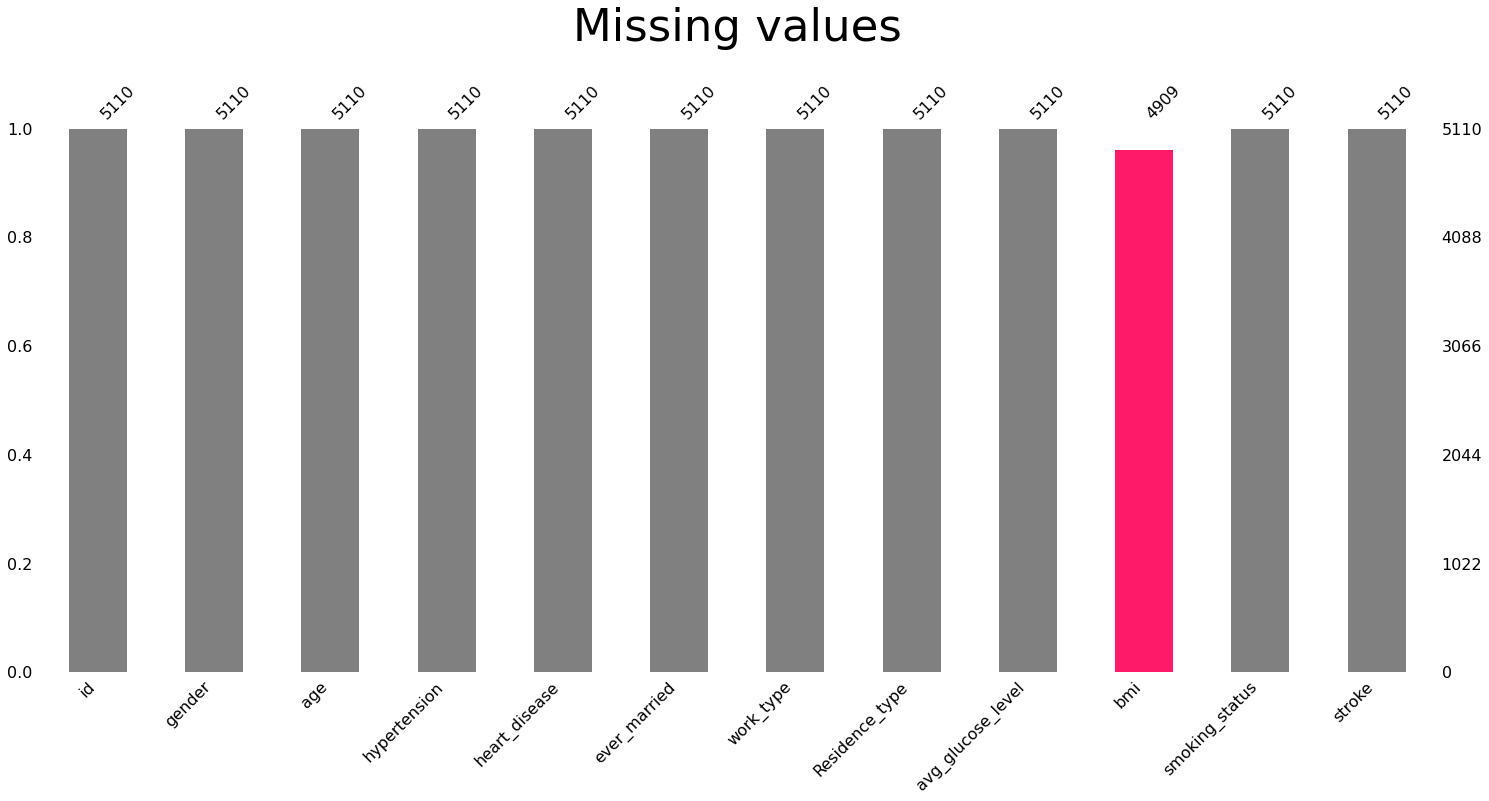

In [5]:
mis_val_colors = []

for col in dataOriginal.columns:
    if dataOriginal[col].isna().sum() != 0:
        mis_val_colors.append('#fe1969')
    else:
        mis_val_colors.append('gray')

msn.bar(dataOriginal, color=mis_val_colors)
plt.title('Missing values', size=45, y=1.15)

Όπως Μπορεί κανείς να δει απο το παραπάνω bar plot ο δείκτης BMI περιέχει κάποιες κενές τιμές ή missing values.
Ας αντικαταστήσουμε τις χαμένες τιμές με τον αριθμιτικό μέσο του δείκτη αυτού. Σαν δεύτερο πείραμα θα αντικαταστήσουμε αυτές τις NaN values με την βοηθεία μιας Linear Regression.

In [6]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
datanew = dataOriginal[['age', 'ever_married', 'smoking_status','avg_glucose_level','bmi']].copy()

traindf = datanew[datanew['bmi'].isnull()==False]
testdf = datanew[datanew['bmi'].isnull()==True]
y = traindf['bmi']
traindf.drop("bmi",axis=1,inplace=True)
cat_columns = [cname for cname in traindf.columns
                        if traindf[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    traindf[col] = encoder.fit_transform(traindf[col])

cat_columns = [cname for cname in testdf.columns
                        if testdf[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    testdf[col] = encoder.fit_transform(testdf[col])    
lr.fit(traindf,y)
testdf.drop("bmi",axis=1,inplace=True)
pred = lr.predict(testdf)
testdf['bmi']= pred


     age ever_married   smoking_status  avg_glucose_level   bmi
0   67.0          Yes  formerly smoked             228.69  36.6
1   61.0          Yes     never smoked             202.21   NaN
2   80.0          Yes     never smoked             105.92  32.5
3   49.0          Yes           smokes             171.23  34.4
4   79.0          Yes     never smoked             174.12  24.0
5   81.0          Yes  formerly smoked             186.21  29.0
6   74.0          Yes     never smoked              70.09  27.4
7   69.0           No     never smoked              94.39  22.8
8   59.0          Yes          Unknown              76.15   NaN
9   78.0          Yes          Unknown              58.57  24.2
10  81.0          Yes     never smoked              80.43  29.7
11  61.0          Yes           smokes             120.46  36.8
12  54.0          Yes           smokes             104.51  27.3
13  78.0          Yes          Unknown             219.84   NaN
14  79.0          Yes     never smoked  

C:\Users\ppetropo\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/471331097.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/471331097.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

## Fill NaN values with mean value of the bmi

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level        bmi  \
0        Private          Urban             228.69  36.600000   
1  Self-employed          Rural             202.21  33.275041   
2        Private          Rural             105.92  32.5

Text(0.5, 1.15, 'Missing values')

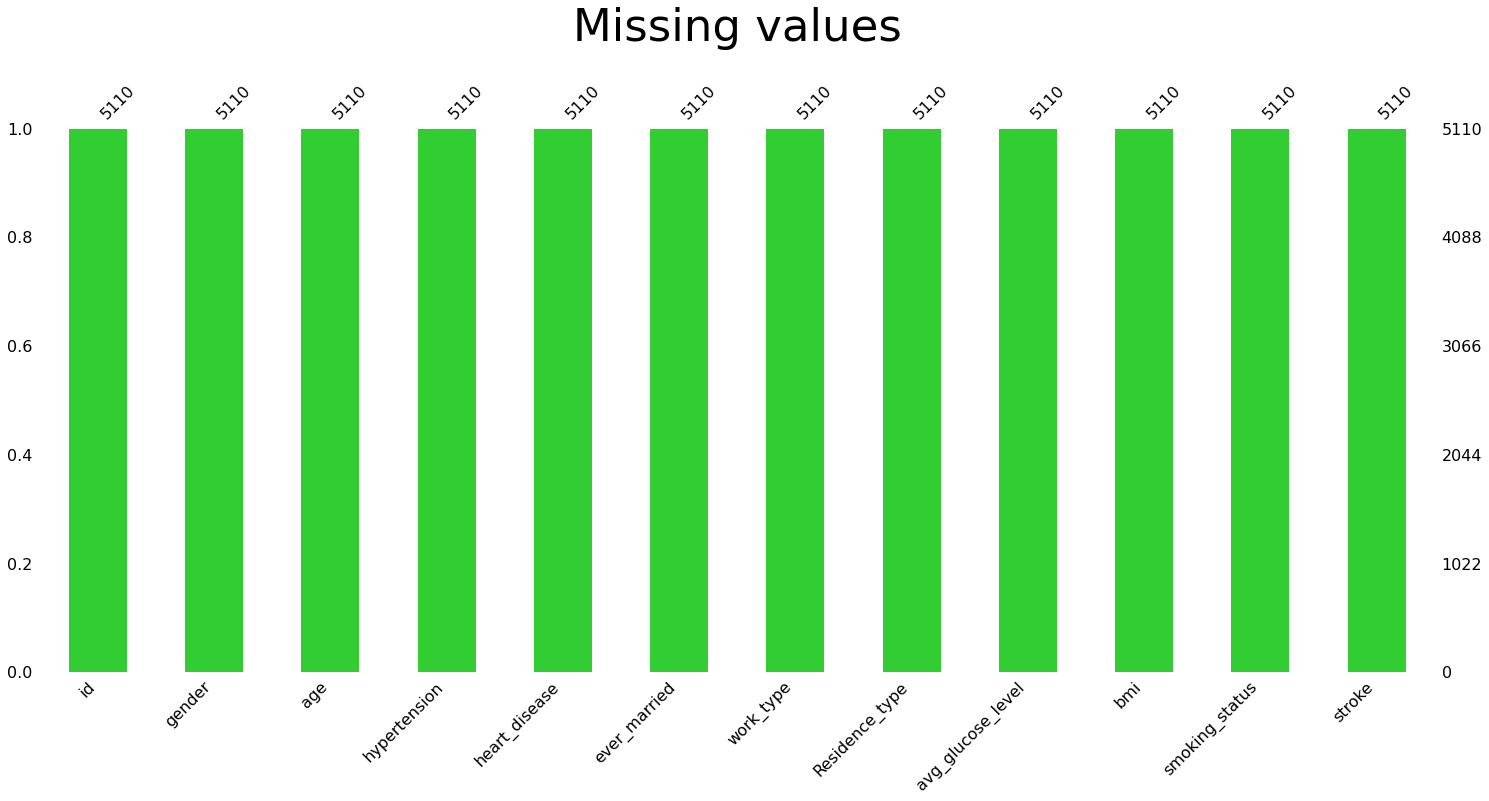

In [7]:
data = dataOriginal


data['bmi'] = data['bmi'].fillna(np.round(data.bmi.mean(), 2))
mis_val_colors_after = []

for col in data.columns:
    if data[col].isna().sum() != 0:
        mis_val_colors_after.append('#fe1969')
    else:
        mis_val_colors_after.append('limegreen')

msn.bar(data, color=mis_val_colors_after)
plt.title('Missing values', size=45, y=1.15)

## Fill NaN values with Multivariate Linear Regression

In [ ]:
data = dataOriginal
# data[data['bmi'].isnull==True] = testdf['bmi']
data['bmi'] = data['bmi'].fillna(testdf['bmi'])
print(data.head(10))
# data['bmi'] = data['bmi'].fillna(np.round(data.bmi.mean(), 2))
mis_val_colors_after = []

for col in data.columns:
    if data[col].isna().sum() != 0:
        mis_val_colors_after.append('#fe1969')
    else:
        mis_val_colors_after.append('limegreen')

msn.bar(data, color=mis_val_colors_after)
plt.title('Missing values', size=45, y=1.15)

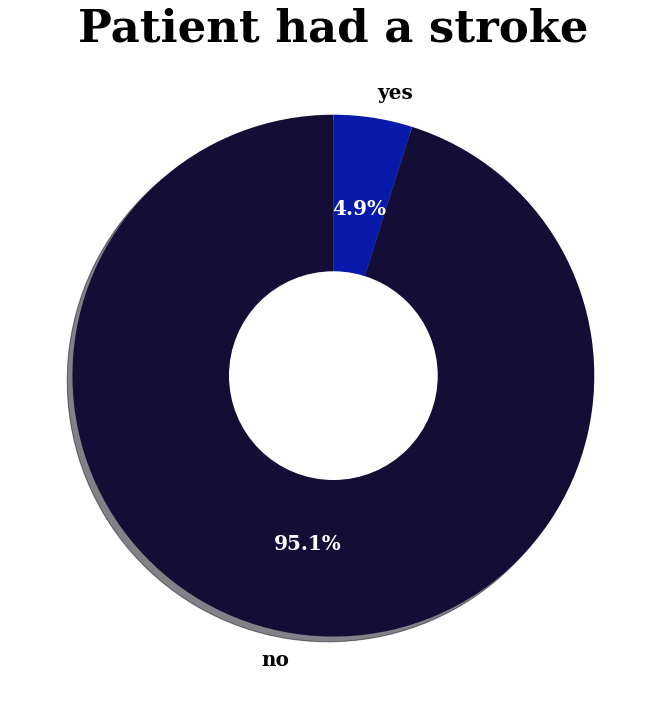

In [8]:
pie_colors = ('#140E36', '#091AAB')

pred_classes = data.stroke.value_counts()

plt.figure(figsize=(17, 12))
patches, texts, pcts = plt.pie(pred_classes,
                               labels=['no', 'yes'],
                               colors=pie_colors,
                               pctdistance=0.65,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 20,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')

hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Patient had a stroke', size=45, **hfont)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
data.drop(['id'], axis=1, inplace=True)

[Text(0, 0, 'Male'), Text(0, 1, 'Female')]

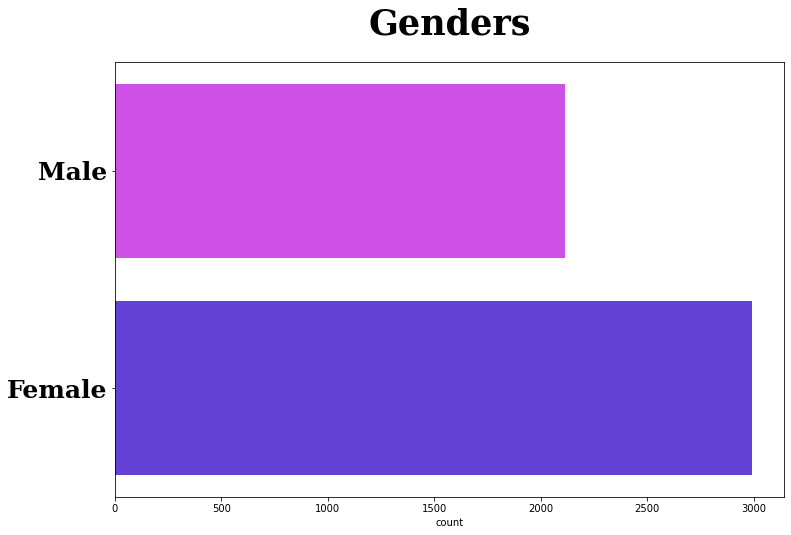

In [9]:
data = data[data.gender != 'Other']
plt.figure(figsize=(12, 8))
gender_plot = sns.countplot(y=data.gender, palette=['#dd38ff', '#5727ed'])
gender_plot.set_title('Genders', fontsize=35, y=1.05, **hfont)
gender_plot.set(ylabel=None)
plt.grid(False)
gender_plot.set_yticklabels(gender_plot.get_yticklabels(), size=25, **hfont)

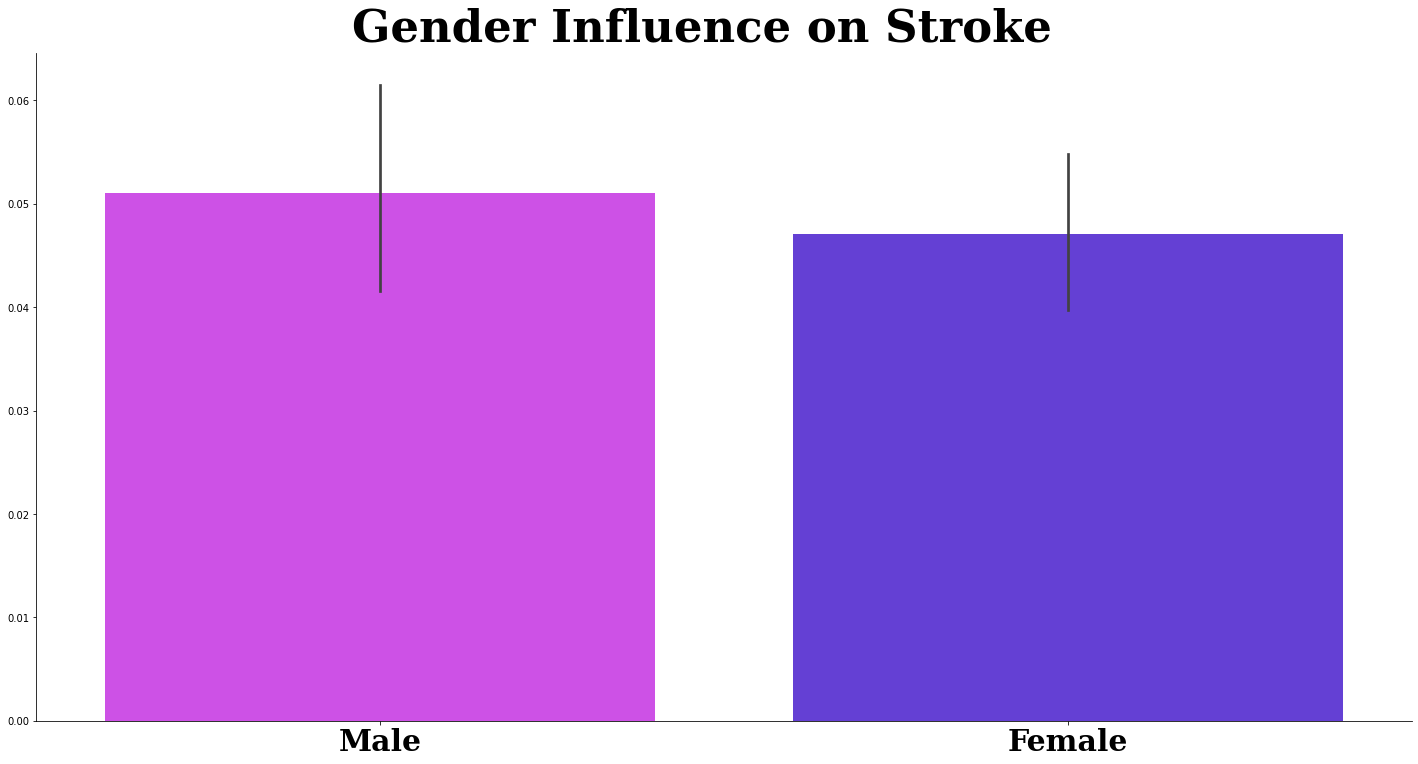

In [10]:
gender_plot = sns.catplot(x='gender', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
gender_plot.set_xticklabels(['Male', 'Female'], size=30, **hfont)
gender_plot.fig.suptitle('Gender Influence on Stroke',
                            size=45, y=1.05, **hfont)
gender_plot.set(xlabel=None, ylabel=None)

Text(0.5, 0, 'Age')

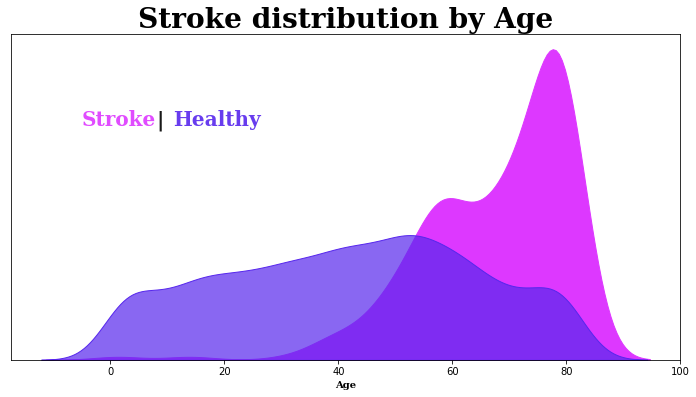

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by Age', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(-5, 0.03, 'Stroke', {'font': 'Serif',
                             'size': '20',
                             'weight': 'bold',
                             'color': '#dd38ff'}, alpha=0.9)

ax.text(8, 0.03, '|', {'font': 'Serif',
                       'size': '20',
                       'weight': 'bold',
                       'color': 'black'}, alpha=0.9)

ax.text(11, 0.03, 'Healthy', {'font': 'Serif',
                              'size': '20',
                              'weight': 'bold',
                              'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[data.stroke == 1],
            x='age', shade=True, ax=ax, color='#dd38ff', alpha=1)
sns.kdeplot(data=data[data.stroke == 0],
            x='age', shade=True, ax=ax, color='#5727ed', alpha=0.7)
plt.xlabel('Age', **hfont)

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/2895794523.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



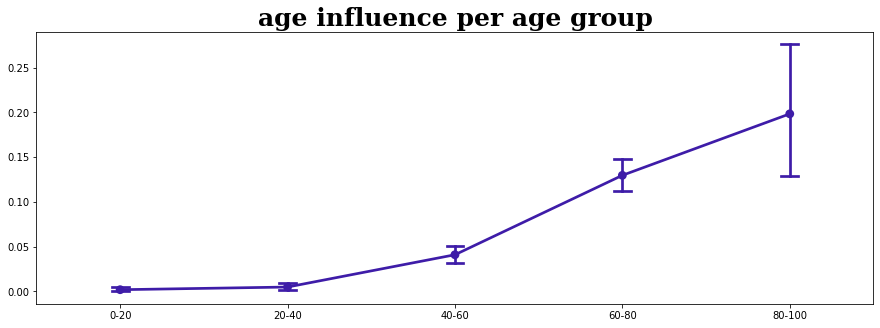

In [12]:
def age_plot(data, col_name):

    age_data = data[[col_name, 'stroke']]
    age_data[col_name] = pd.cut(age_data[col_name],
                               bins=[0, 20, 40, 60, 80, 100],
                               labels=['0-20',
                                       '20-40',
                                       '40-60',
                                       '60-80',
                                       '80-100'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=age_data, color=color)
    plot.set_title(f'{col_name} influence per age group', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


age_plot(data, 'age')

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

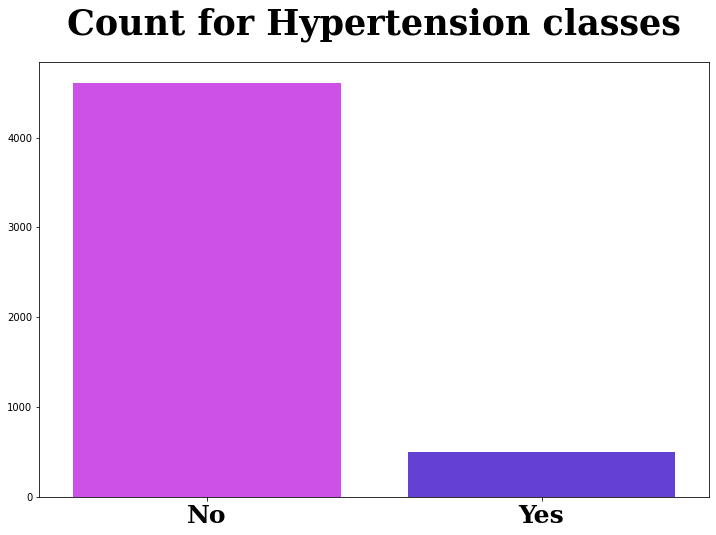

In [13]:
plt.figure(figsize=(12, 8))
hypertension_plot = sns.countplot(x=data.hypertension,
                            palette=['#dd38ff', '#5727ed'])
hypertension_plot.set_title('Count for Hypertension classes',
                      fontsize=35, y=1.05, **hfont)
hypertension_plot.set(xlabel=None, ylabel=None)
plt.grid(False)
hypertension_plot.set_xticklabels(['No', 'Yes'], size=25, **hfont)

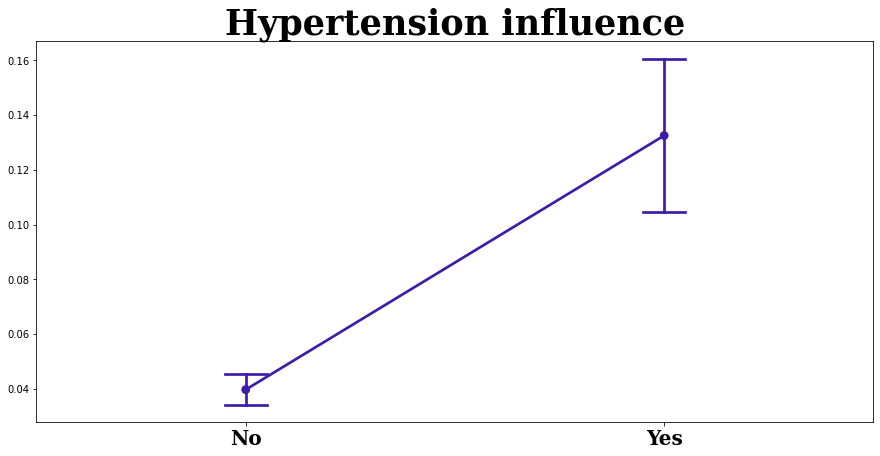

In [14]:
def hypertension_plot(data, col_name):

    hypertension_data = data[[col_name, 'stroke']]

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 7))
    hypertension = sns.pointplot(x=col_name, y='stroke',
                           dodge=0.1, capsize=.1,
                           data=hypertension_data,
                           color=color)
    hypertension.set_title('Hypertension influence',
                            fontsize=35, **hfont)
    hypertension.set(xlabel=None, ylabel=None)
    hypertension.set_xticklabels(['No', 'Yes'], size=20, **hfont)


hypertension_plot(data, 'hypertension')

Text(0.5, 1.0, 'Heart Disease')

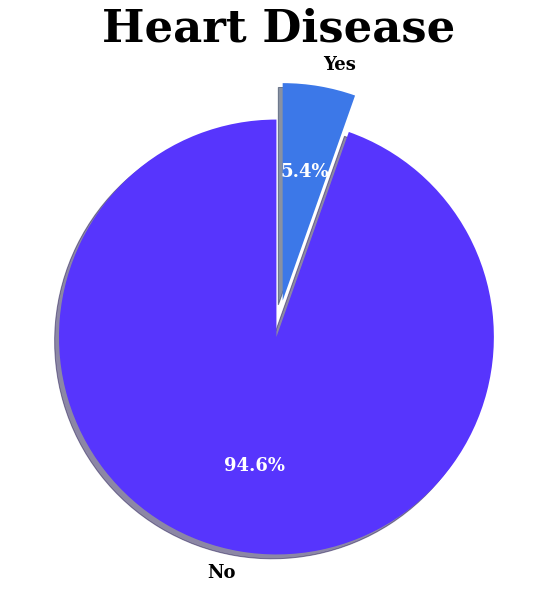

In [15]:
heart_dis_data = data.heart_disease.value_counts()

explode = (0.07, 0.1)
pie_colors = ('#5735FD', '#3C78E8')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(heart_dis_data,
                               labels=['No', 'Yes'],
                               explode=explode,
                               colors=pie_colors,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 18,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')
plt.title('Heart Disease', size=45, **hfont)

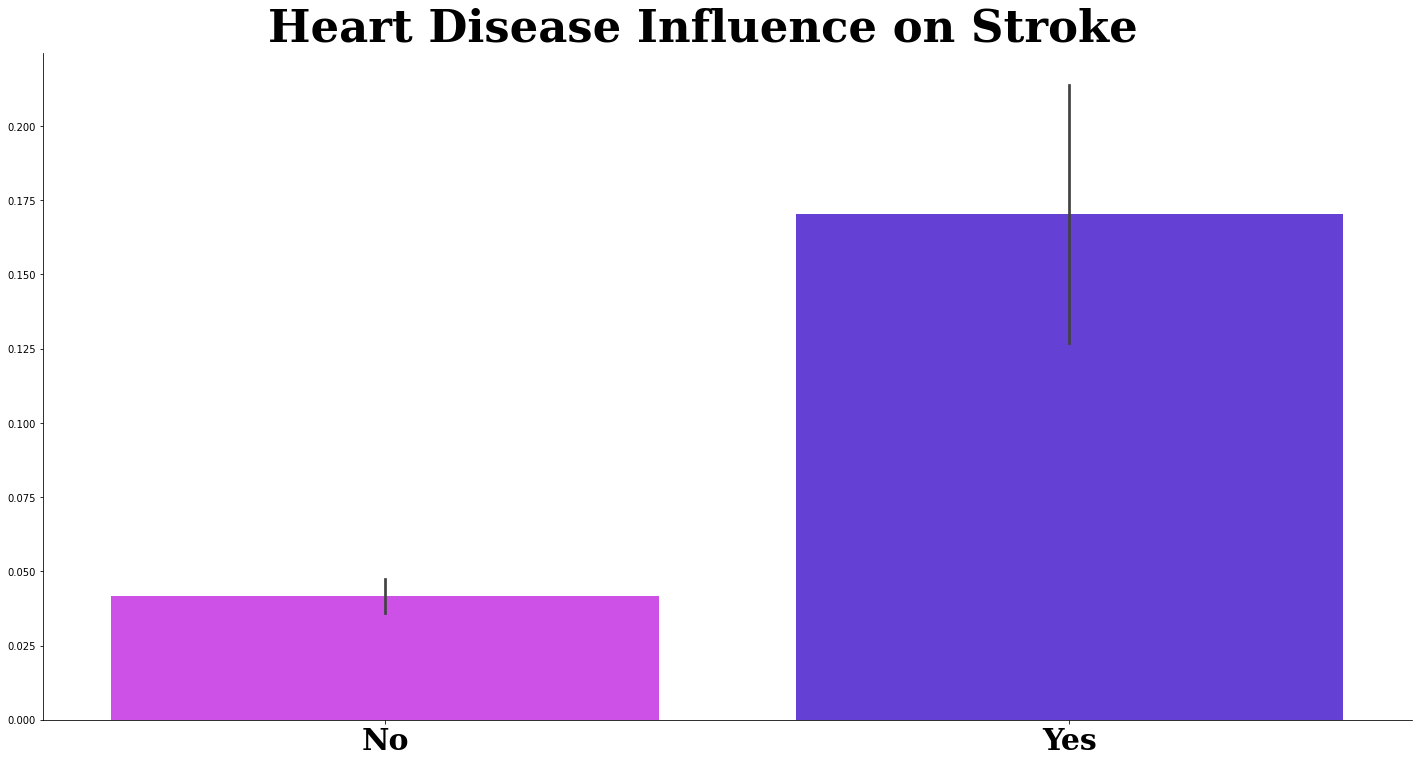

In [16]:
heart_dis_plot = sns.catplot(x='heart_disease', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
heart_dis_plot.set_xticklabels(['No', 'Yes'], size=30, **hfont)
heart_dis_plot.fig.suptitle('Heart Disease Influence on Stroke',
                            size=45, y=1.05, **hfont)
heart_dis_plot.set(xlabel=None, ylabel=None)

Text(0.5, 1.0, 'Married (y/n)')

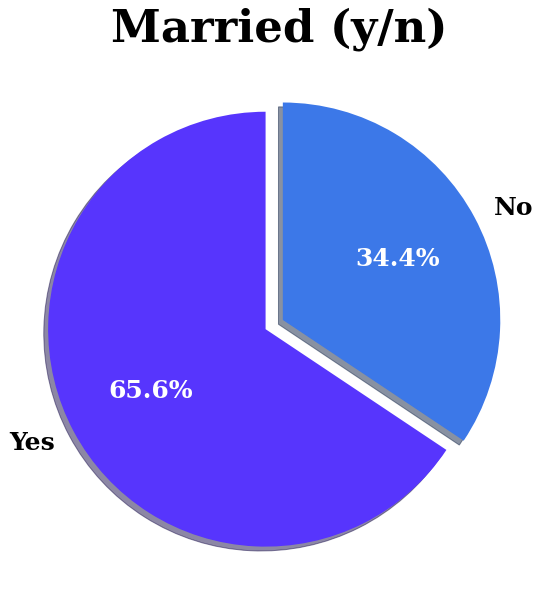

In [17]:
married_data = data.ever_married.value_counts()

explode = (0.07, 0.02)
pie_colors = ('#5735FD', '#3C78E8')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(married_data,
                               labels=married_data.index,
                               explode=explode,
                               colors=pie_colors,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 25,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif'})
plt.setp(pcts, color='white')
plt.title('Married (y/n)', size=45, **hfont)

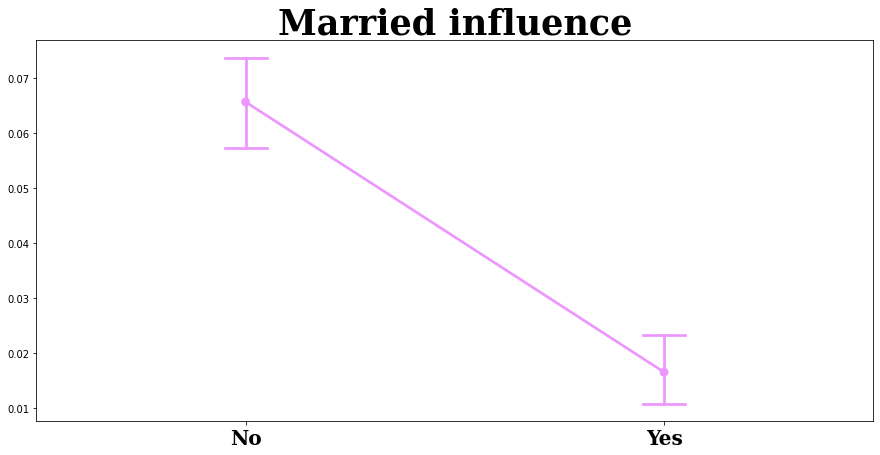

In [18]:
def married_plot(data, col_name):

    married_data = data[[col_name, 'stroke']]

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 7))
    married = sns.pointplot(x=col_name, y='stroke',
                            dodge=0.1, capsize=.1,
                            data=married_data,
                            color=color)
    married.set_title('Married influence', fontsize=35, **hfont)
    married.set(xlabel=None, ylabel=None)
    married.set_xticklabels(['No', 'Yes'], size=20, **hfont)


married_plot(data, 'ever_married')

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, '')]

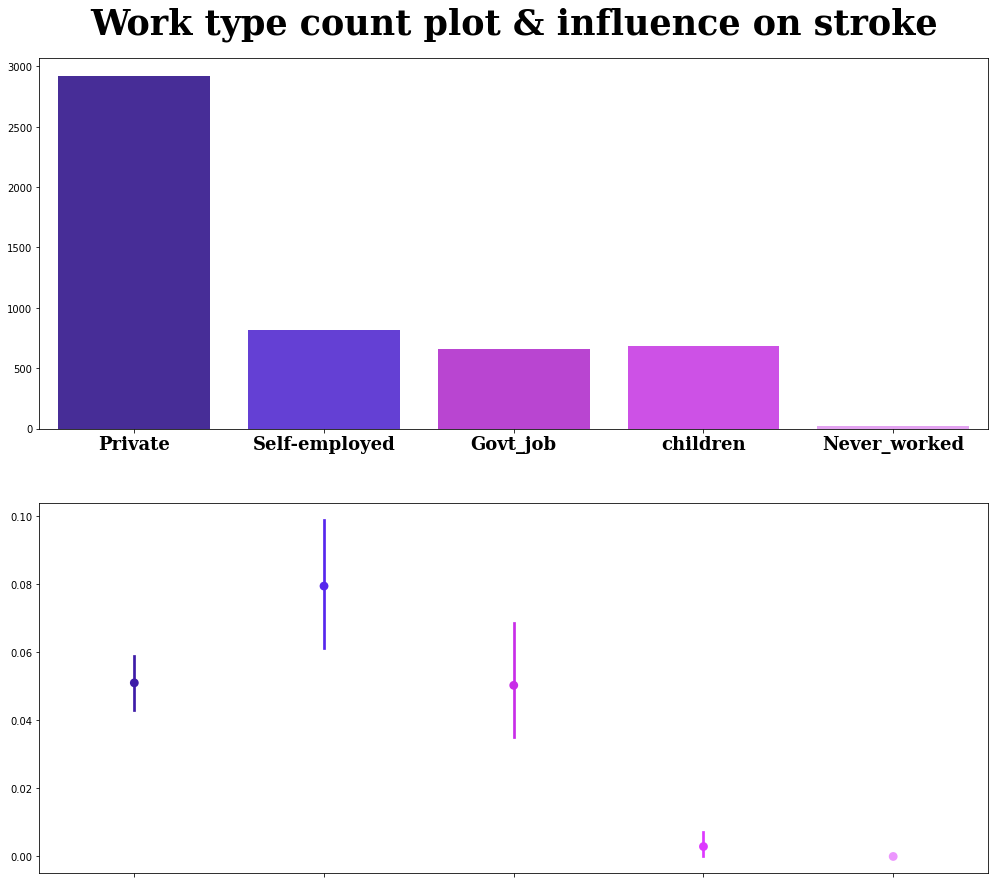

In [19]:
fig = plt.figure(figsize=(17, 15))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
work_type_plot = sns.countplot(x=data.work_type, ax=ax1, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
work_type_plot.set_title('Work type count plot &'
                         ' influence on stroke',
                         fontsize=35, y=1.05, **hfont)
work_type_plot.set(xlabel=None,
                   ylabel=None)
work_type_plot.set_xticklabels(work_type_plot.get_xticklabels(),
                                size=18, **hfont)


ax2 = fig.add_subplot(grid[1, :])
work_type_cat = sns.pointplot(x=data.work_type, y='stroke', data=data,
             ax=ax2, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
work_type_cat.set(xlabel=None,
                   ylabel=None)
work_type_cat.set_xticklabels([])

Θα μπορούσε κανείς να συμπαράνει οτι τα παιδιά και αυτοί που δεν έχουν ποτέ δουλέψει το risk για heart disease προσεγγίζει το μηδέν. 

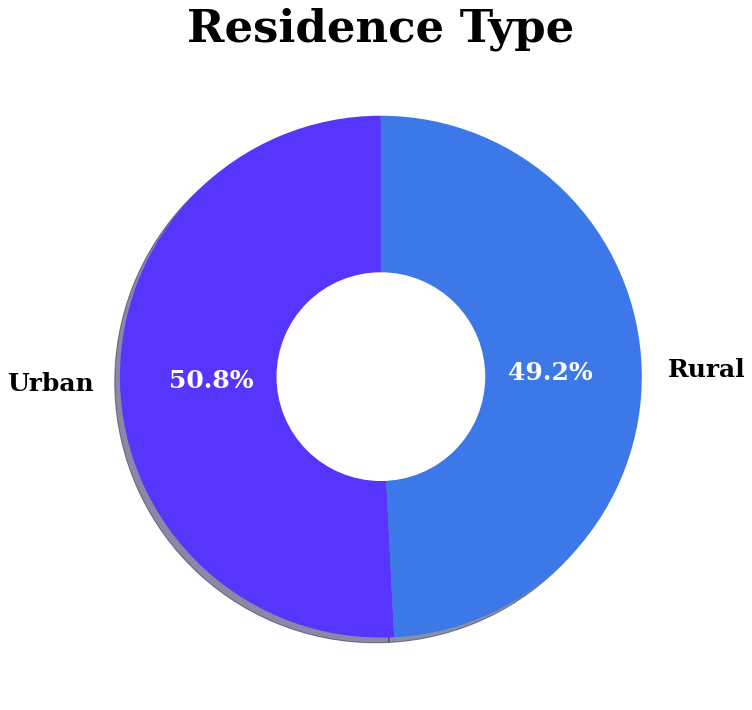

In [20]:
residence_data = data.Residence_type.value_counts()

explode = (0.1, 0.1)
plt.figure(figsize=(17, 12))
patches, texts, pcts = plt.pie(residence_data,
                               labels=residence_data.index,
                               colors=pie_colors,
                               pctdistance=0.65,
                               shadow=True,
                               startangle=90,
                               autopct='%1.1f%%',
                               textprops={'fontsize': 25,
                                           'color': 'black',
                                           'weight': 'bold',
                                           'family': 'serif'})
plt.setp(pcts, color='white')

hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Residence Type', size=45, **hfont)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

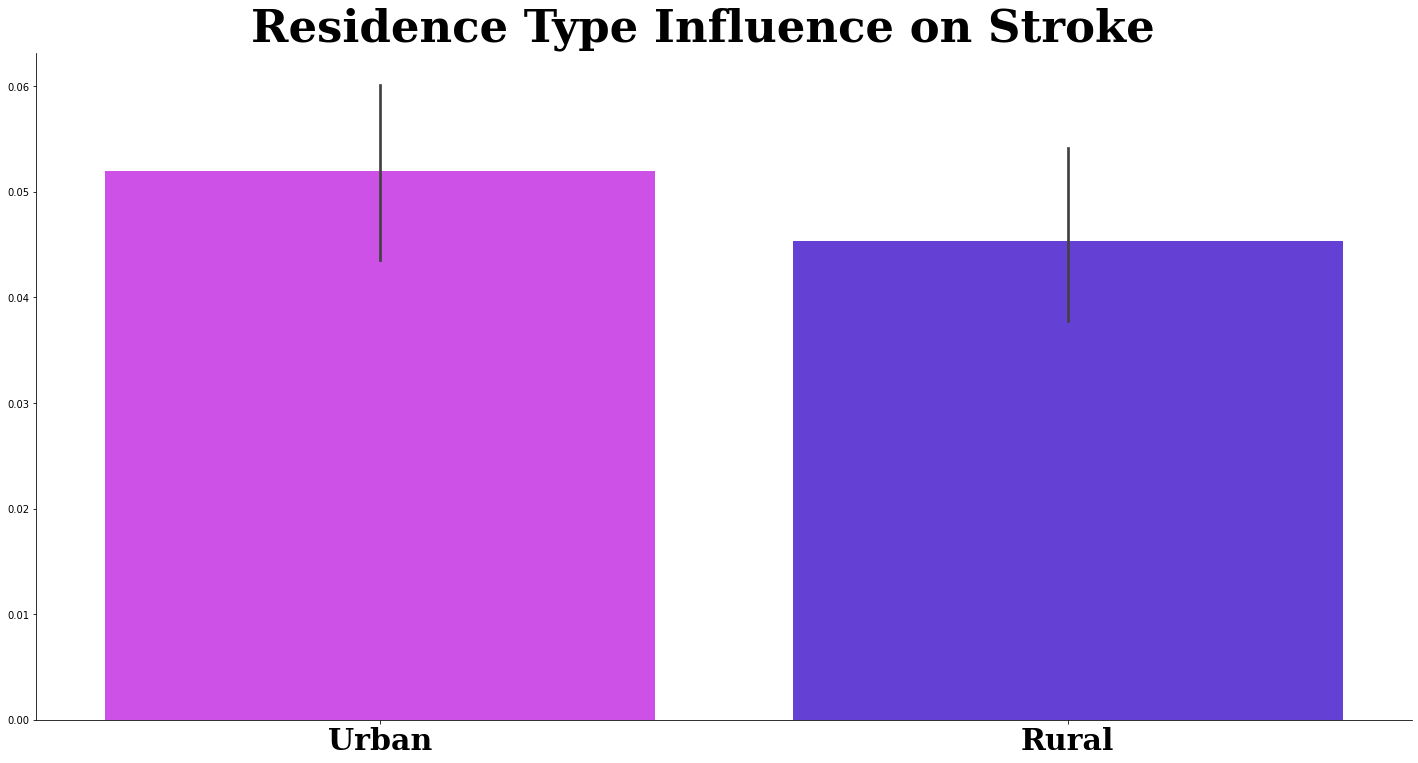

In [21]:
residence_plot = sns.catplot(x='Residence_type', y='stroke', data=data,
                             height=10, aspect=2, kind='bar',
                             palette=['#dd38ff', '#5727ed'])
residence_plot.set_xticklabels(['Urban', 'Rural'],
                               size=30, **hfont)
residence_plot.fig.suptitle('Residence Type Influence on Stroke',
                            size=45, y=1.05, **hfont)
residence_plot.set(xlabel=None, ylabel=None)

Text(0.5, 0, 'AVG glucose lvl')

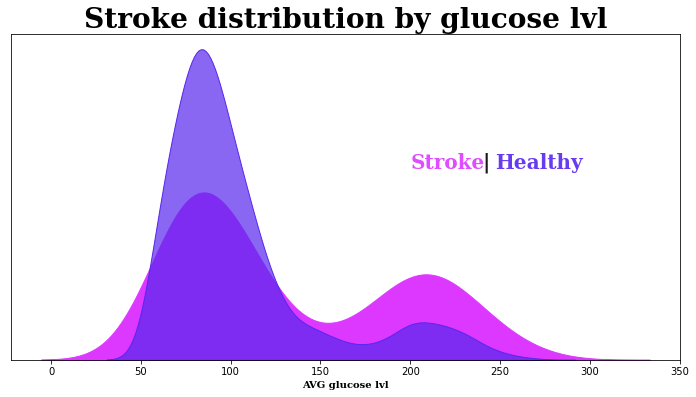

In [22]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by glucose lvl', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(200, 0.01, 'Stroke', {'font': 'Serif',
                              'size': '20',
                              'weight': 'bold',
                              'color': '#dd38ff'}, alpha=0.9)

ax.text(240, 0.01, '|', {'font': 'Serif',
                         'size': '20',
                         'weight': 'bold',
                         'color': 'black'}, alpha=0.9)

ax.text(247, 0.01, 'Healthy', {'font': 'Serif',
                               'size': '20',
                               'weight': 'bold',
                               'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[data.stroke == 1],
            x='avg_glucose_level', shade=True, ax=ax, color='#dd38ff',
            alpha=1)
sns.kdeplot(data=data[data.stroke == 0],
            x='avg_glucose_level', shade=True, ax=ax, color='#5727ed',
            alpha=0.7)
plt.xlabel('AVG glucose lvl', **hfont)

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/1636714420.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



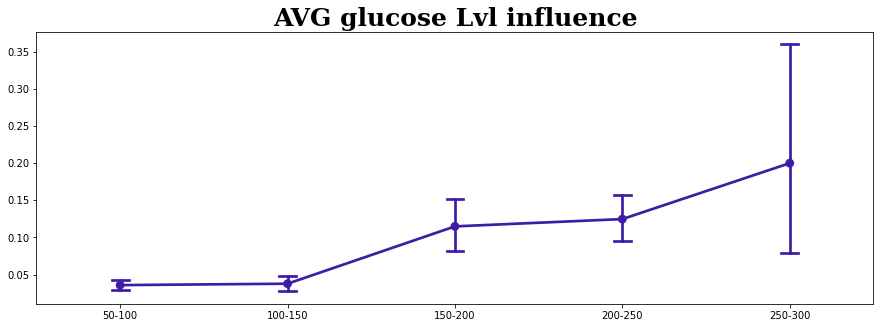

In [23]:
def avg_glucose_plot(data, col_name):

    avg_glucose_data = data[[col_name, 'stroke']]
    avg_glucose_data[col_name] = pd.cut(avg_glucose_data[col_name],
                               bins=[50, 100, 150, 200, 250, 300],
                               labels=['50-100',
                                       '100-150',
                                       '150-200',
                                       '200-250',
                                       '250-300'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=avg_glucose_data, color=color)
    plot.set_title(f'AVG glucose Lvl influence', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


avg_glucose_plot(data, 'avg_glucose_level')

Text(0.5, 0, 'BMI')

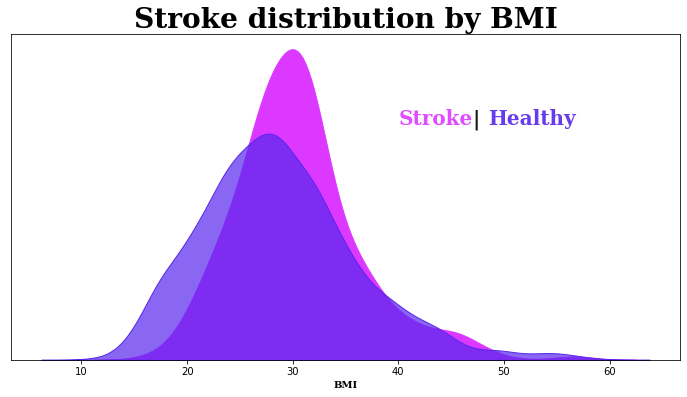

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Stroke distribution by BMI', size=28, **hfont)
ax.grid(False)
ax.axes.get_yaxis().set_visible(False)
ax.text(40, 0.06, 'Stroke', {'font': 'Serif',
                             'size': '20',
                             'weight': 'bold',
                             'color': '#dd38ff'}, alpha=0.9)

ax.text(47, 0.06, '|', {'font': 'Serif',
                        'size': '20',
                        'weight': 'bold',
                        'color': 'black'}, alpha=0.9)

ax.text(48.5, 0.06, 'Healthy', {'font': 'Serif',
                                'size': '20',
                                'weight': 'bold',
                                'color': '#5727ed'}, alpha=0.9)

sns.kdeplot(data=data[(data.stroke == 1) & (data.bmi < 60)],
            x='bmi', shade=True, ax=ax, color='#dd38ff',
            alpha=1)
sns.kdeplot(data=data[(data.stroke == 0) & (data.bmi < 60)],
            x='bmi', shade=True, ax=ax, color='#5727ed',
            alpha=0.7)
plt.xlabel('BMI', **hfont)

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/513898866.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



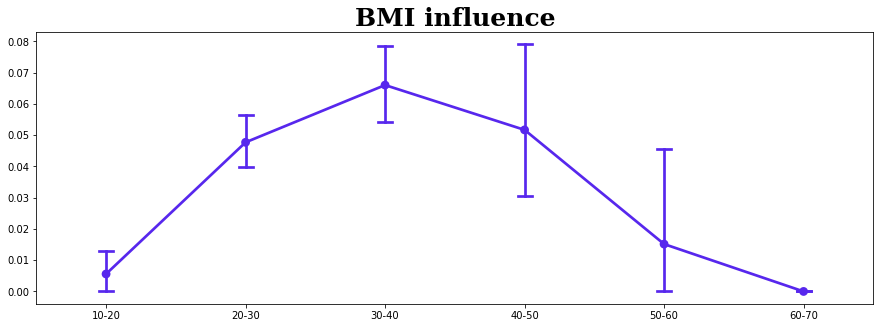

In [25]:
def bmi_plot(data, col_name):

    bmi_data = data[[col_name, 'stroke']]
    bmi_data[col_name] = pd.cut(bmi_data[col_name],
                               bins=[10, 20, 30, 40, 50, 60, 70],
                               labels=['10-20',
                                       '20-30',
                                       '30-40',
                                       '40-50',
                                       '50-60',
                                       '60-70'])

    color = np.random.choice(['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'], 1)[0]
    plt.figure(figsize=(15, 5))
    plot = sns.pointplot(x=col_name, y='stroke',
                  dodge=0.1, capsize=.1, data=bmi_data, color=color)
    plot.set_title(f'BMI influence', fontsize=25, **hfont)
    plot.set(xlabel=None, ylabel=None)


bmi_plot(data, 'bmi')

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

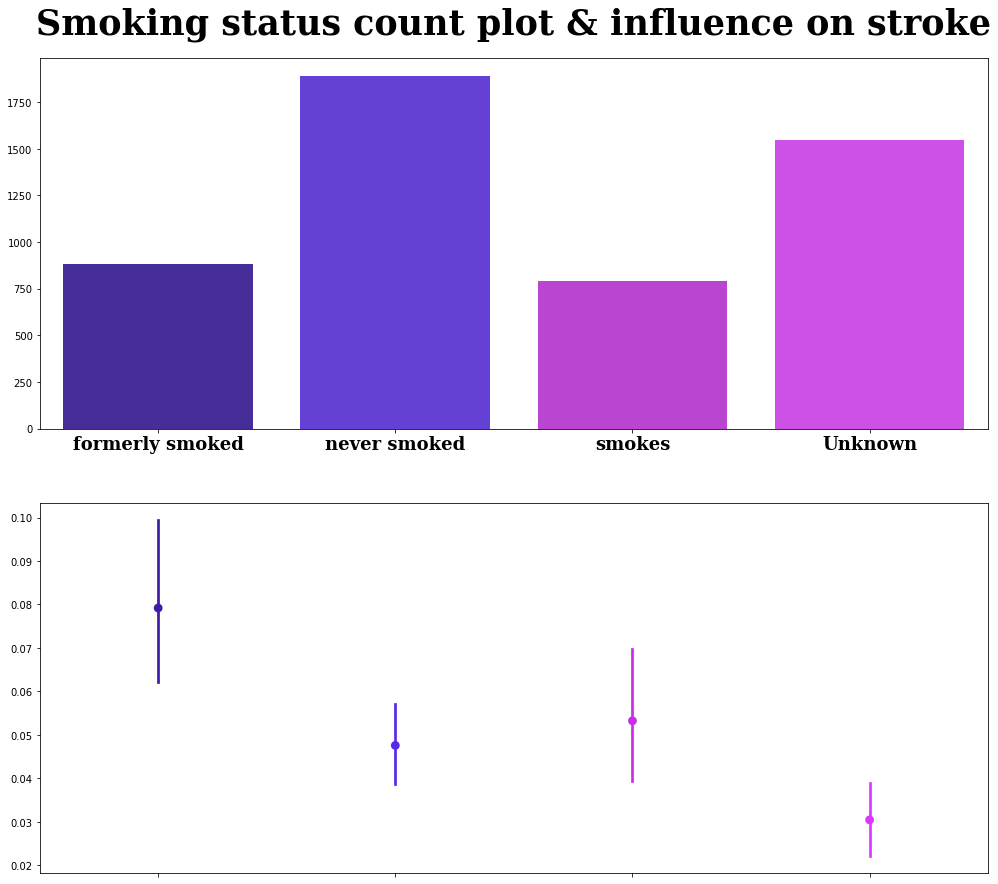

In [26]:
fig = plt.figure(figsize=(17, 15))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
smoke_plot = sns.countplot(x=data.smoking_status, ax=ax1, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
smoke_plot.set_title('Smoking status count plot &'
                         ' influence on stroke',
                         fontsize=35, y=1.05, **hfont)
smoke_plot.set(xlabel=None,
                   ylabel=None)
smoke_plot.set_xticklabels(smoke_plot.get_xticklabels(),
                                size=18, **hfont)


ax2 = fig.add_subplot(grid[1, :])
smoke_cat = sns.pointplot(x=data.smoking_status, y='stroke', data=data,
             ax=ax2, palette=['#3E1CA8', '#5727ed', '#C82EE8', '#dd38ff', '#EC96FE'])
smoke_cat.set(xlabel=None,
                   ylabel=None)
smoke_cat.set_xticklabels([])

In [27]:
cat_columns = [cname for cname in data.columns
                        if data[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    data[col] = encoder.fit_transform(data[col])

C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/508416172.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

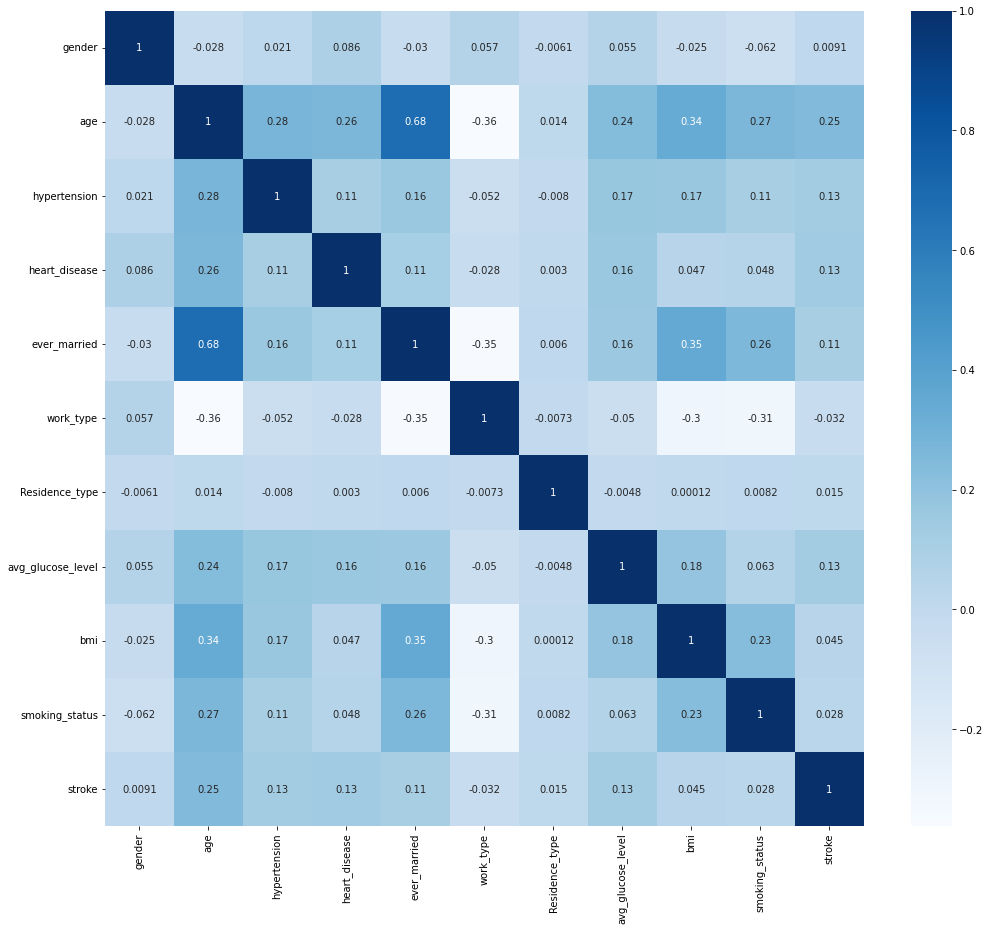

In [28]:
plt.figure(figsize=(17, 15))

corr_mask = np.triu(data.corr())
h_map = sns.heatmap(data.corr(),  annot= True, cmap='Blues')
h_map

Απο τον παραπάνω correlation matrix μπορεί κανείς να δει οτι τα features που έχουν την μεγαλύτερη συσχέτηση είναι:
 1. age
 2. ever_married
 3. smoking_status
 4. avg_glucose_level

In [ ]:
# print(data.head(10))
# std=StandardScaler()
# columns = ['avg_glucose_level','bmi','age']
# scaled = std.fit_transform(data[['avg_glucose_level','bmi','age']])
# scaled = pd.DataFrame(scaled,columns=columns)
# data=data.drop(columns=columns,axis=1)
# data=data.merge(scaled, left_index=True, right_index=True, how = "left")
# print(data.head(10))


In [29]:
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectKBest,chi2
from sklearn import naive_bayes, svm,metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
# !pip install imblearn
from imblearn.over_sampling import SMOTE
Xorig = data.drop(['stroke'], axis=1)
yorig = data.stroke
sm = SMOTE(random_state=0)
X, y = sm.fit_resample(Xorig, yorig)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [30]:
X_names = Xorig.columns.values
print(X_names)
p_value_limit = 0.98
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2test, p = feature_selection.chi2(X_train,y_train==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()

# praktika h Chi^2 einai
# alpha = 1.0 - prob
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (fail to reject H0)')

for cat in np.unique(data["stroke"]):
    print("# {}:".format(cat))
    print(" . selected features:", len(features[features["Y"]==cat]))
    print(" . top features:",",".join(features[features["Y"]==cat]["feature"].values[:20]))
    # print(" . top features scores:",",".join(str(features[features["Y"]==cat]["score"].values[:10])))
    print(" ")

StatisticalTest = SelectKBest(score_func=chi2, k=4)
fit = StatisticalTest.fit(X_train, y_train)
X_new=StatisticalTest.fit_transform(X_train, y_train)
X_test=StatisticalTest.fit_transform(X_test, y_test)
# print(X_new)

['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']
# 0:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 
# 1:
 . selected features: 8
 . top features: gender,age,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,ever_married
 


In [31]:
list_alpha = np.arange(1/100000, 10, 0.1)
param_grid = {'alpha':list_alpha
               }
grid = GridSearchCV(naive_bayes.ComplementNB(), param_grid, refit = True, verbose = 0)
#ComplementNB()

grid.fit(X_new, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)
#
# # print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'C':[0.01,0.1,1,1.1,1.2,1.3,1.5,2,10,100,1000,2000,5000],
              'kernel':['rbf','linear'],
              'gamma':['scale','auto']

              }
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0)


grid.fit(X_new, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'C':[0.001, 0.01, 0.1, 1.0,1.1,1.2,10,100,1000],
              'max_iter': [200,500,1000],
              'solver':['newton-cg','lbfgs']
              }
grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 0)


grid.fit(X_new, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'n_estimators':[10,50,100,200,300,500],
              'learning_rate': [0.001,0.01,0.1,1,10],
              'max_depth':[10,20,50,70,100]
              }
grid = GridSearchCV(GradientBoostingClassifier(loss = 'exponential'), param_grid, refit = True, verbose = 0)


grid.fit(X_new, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'n_estimators':[10,50,100,200,300,500]
              
              }
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 0)


grid.fit(X_new, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

{'alpha': 5.10001}
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       976
           1       0.60      0.63      0.61       968

    accuracy                           0.60      1944
   macro avg       0.60      0.60      0.60      1944
weighted avg       0.60      0.60      0.60      1944



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\ppetropo\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ppetropo\AppData\Local\Temp/ipykernel_6516/1530047124.py", line 23, in <module>
    grid.fit(X_new, y_train)
  File "c:\users\ppetropo\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "c:\users\ppetropo\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "c:\users\ppetropo\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py", line 838, in evaluate_candidates
    out = parallel(
  File "c:\users\ppetropo\appdata\local\programs\python\python39\lib\site-packages\joblib\

TypeError: object of type 'NoneType' has no len()

In [ ]:

clf2 = naive_bayes.ComplementNB(alpha = 5.00001).fit(X_new,y_train)
y_pred2 = clf2.predict(X_test)
predicted_prob2 = clf2.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("NB")
print(metrics.classification_report(y_pred2,y_test))
plt.figure(figsize = (12,8))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
#================================================================================
clf1 = svm.SVC(kernel='linear',C=0.1,gamma='auto',probability=True).fit(X_new,y_train)
y_pred = clf1.predict(X_test)
predicted_prob1 = clf1.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("SVM RBF")
print(metrics.classification_report(y_pred,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()

#================================================================================
clf3 = LogisticRegression(solver='newton-cg',C=10,max_iter=200).fit(X_new,y_train)
y_pred3 = clf3.predict(X_test)
predicted_prob3 = clf3.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred3)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("Logistic Regression")
print(metrics.classification_report(y_pred3,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
#================================================================================
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, loss = 'exponential', max_depth=70).fit(X_new, y_train)
y_pred = clf.predict(X_test)
predicted_prob = clf.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("GBC")
print(metrics.classification_report(y_pred,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
#================================================================================

forest = RandomForestClassifier(n_estimators = 100).fit(X_new,y_train)
y_pred4 = forest.predict(X_test)
predicted_prob4 = forest.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred4)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("Random Forest")
print(metrics.classification_report(y_pred4,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()

for clf, label in zip([clf1, clf2,clf3,clf,forest],
                      ['SVM',
                       'Naive Bayes',
                       'Logistic Regression',
                       'GradientBoosting',
                       'Random Forest'
                       ]):

    scoresTest = cross_val_score(clf, X_test, y_test,
                                             cv=3, scoring='accuracy')
    scores2Test = cross_val_score(clf, X_test, y_test,
                                             cv=3, scoring='f1_macro')
    print("Accuracy on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scoresTest.mean(), scoresTest.std(), label))
    print("F1-Score on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scores2Test.mean(), scores2Test.std(), label))

    scoresTrain = cross_val_score(clf, X_new, y_train,
                                                 cv=3, scoring='accuracy')
    scores2Train = cross_val_score(clf, X_new, y_train,
                                                  cv=3, scoring='f1_macro')
    print("Accuracy on Train set: %0.3f (+/- %0.3f) [%s]"
          % (scoresTrain.mean(), scoresTrain.std(), label))
    print("F1-Score on Train set: %0.3f (+/- %0.3f) [%s]"
          % (scores2Train.mean(), scores2Train.std(), label))

In [ ]:
list_alpha = np.arange(1/100000, 10, 0.1)
param_grid = {'alpha':list_alpha
               }
grid = GridSearchCV(naive_bayes.ComplementNB(), param_grid, refit = True, verbose = 5)
#ComplementNB()

grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)
#
# # print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'C':[0.01,0.1,1,1.1,1.2,1.3,1.5,2,10,100,1000,2000,5000],
              'kernel':['rbf','linear'],
              'gamma':['scale','auto']

              }
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 5)


grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'C':[0.001, 0.01, 0.1, 1.0,1.1,1.2,10,100,1000],
              'max_iter': [200,500,1000],
              'solver':['newton-cg','lbfgs']
              }
grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 5)


grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'n_estimators':[10,50,100,200,300,500],
              'learning_rate': [0.001,0.01,0.1,1,10],
              'max_depth':[10,20,50,70,100]
              }
grid = GridSearchCV(GradientBoostingClassifier(loss = 'exponential'), param_grid, refit = True, verbose = 5)


grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

param_grid = {'n_estimators':[10,50,100,200,300,500]
              
              }
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 5)


grid.fit(X_train, y_train)
# print best parameter after tuning
print(grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(y_test, grid_predictions))

In [ ]:
clf2 = naive_bayes.ComplementNB().fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)
predicted_prob2 = clf2.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("NB")
print(metrics.classification_report(y_pred2,y_test))
plt.figure(figsize = (12,8))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
#================================================================================
clf1 = svm.SVC(kernel='linear',C=0.1,gamma='auto',probability=True).fit(X_train,y_train)
y_pred = clf1.predict(X_test)
predicted_prob1 = clf1.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("SVM RBF")
print(metrics.classification_report(y_pred,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()

#================================================================================
clf3 = LogisticRegression(solver='newton-cg',C=10,max_iter=200).fit(X_train,y_train)
y_pred3 = clf3.predict(X_test)
predicted_prob3 = clf3.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred3)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("Logistic Regression")
print(metrics.classification_report(y_pred3,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
#================================================================================
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, loss = 'exponential', max_depth=70).fit(X_train, y_train)
y_pred = clf.predict(X_test)
predicted_prob = clf.predict_proba(X_test)
m_confusion_test = metrics.confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(m_confusion_test, index = ['Stroke', 'Normal'],
                             columns = ['Stroke', 'Normal'])
print("GBC")
print(metrics.classification_report(y_pred,y_test))
sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05, **hfont)
plt.xlabel('Predicted values', fontsize = 20, **hfont)
plt.ylabel('True values', fontsize = 20, **hfont)
plt.show()
for clf, label in zip([clf1, clf2,clf3,clf],
                      ['SVM',
                       'Naive Bayes',
                       'Logistic Regression'
                       ]):

    scoresTest = cross_val_score(clf, X_test, y_test,
                                             cv=3, scoring='accuracy')
    scores2Test = cross_val_score(clf, X_test, y_test,
                                             cv=3, scoring='f1_macro')
    print("Accuracy on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scoresTest.mean(), scoresTest.std(), label))
    print("F1-Score on Test set: %0.3f (+/- %0.3f) [%s]"
          % (scores2Test.mean(), scores2Test.std(), label))

    scoresTrain = cross_val_score(clf, X_train, y_train,
                                                 cv=3, scoring='accuracy')
    scores2Train = cross_val_score(clf, X_train, y_train,
                                                  cv=3, scoring='f1_macro')
    print("Accuracy on Train set: %0.3f (+/- %0.3f) [%s]"
          % (scoresTrain.mean(), scoresTrain.std(), label))
    print("F1-Score on Train set: %0.3f (+/- %0.3f) [%s]"
          % (scores2Train.mean(), scores2Train.std(), label))

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px
from plotly.offline import iplot
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
# pca= PCA(n_components=1)
X_embedded  = tsne.fit_transform(X_test)
df = pd.DataFrame(columns=['tsne_1','tsne_2','probas','tweet','Sentiment'])
df['tsne_1'] = X_embedded[:, 0]
# df['pca'] = X_embedded[:, 0]
df['tsne_2'] = X_embedded[:, 1]
df['probas'] = pd.DataFrame(predicted_prob[:,1])
df['gender'] = data['gender']
df['stroke'] = data['stroke']
    # print(df.shape)
    # print(df['tsne_1'].head(2))
fig = px.scatter(df, x='probas', y='tsne_1', hover_name= 'gender',color='stroke',size_max=45
                     , template='plotly_white', title='unigram-Bigram similarity and frequency per Sentiment from LR', labels={'words': 'Avg. Length<BR>(words)'}
                     , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
# fig.show()

iplot(fig)